# Final project
Team: Franklin st. bulls
Sherry, Jim, Valerie, Vladimir

## Pairs Trading Strategies Using Python: finding best pair in S&P 500

### Pull data from Wiki and Yahoo Finance and Wiki

In [1]:
import pandas as pd
import yfinance as yf
import datetime

import warnings #just remove any annoying warnings
warnings.filterwarnings("ignore")

#get S&P 500 components from wiki and write it to csv
table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies') 
df = table[0]

df.to_csv('S&P500-Info.csv')
df.to_csv("S&P500-Symbols.csv", columns=['Symbol'])

start_date = datetime.date(2019, 1, 1) # period start date
end_date = datetime.date(2021, 1, 1) # period end date

#get stocks prices from Yahoo finance over chosen period
data = yf.download(df['Symbol'].to_list(), start=start_date, end=end_date)
data = data["Open"]

[*********************100%***********************]  505 of 505 completed

2 Failed downloads:
- BRK.B: No data found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted


### Data cleaning

In [2]:
for each in data:
    data[each] = pd.to_numeric(data[each], errors='coerce') #convert column convert to numeric

data = data.dropna(axis = 0,  how="all") #drop all rows with NaN in columns except Date
data = data.dropna(axis = 1, how="all") #Drop empty columns (not listed tickets)

data.to_csv('Stocks_data.csv')

data.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,66.500000,31.459999,156.160004,38.722500,91.239998,73.739998,315.940002,70.389999,138.929993,219.910004,...,49.160000,83.389999,67.349998,36.959999,65.709999,91.089996,102.919998,155.990005,40.029999,84.510002
2019-01-03,65.529999,31.690001,158.229996,35.994999,88.639999,74.089996,307.250000,68.739998,139.130005,220.880005,...,48.270000,85.019997,70.000000,37.980000,66.190002,91.000000,101.699997,153.850006,41.529999,84.070000
2019-01-04,64.089996,30.440001,164.169998,36.132500,87.750000,73.660004,305.309998,67.120003,138.119995,219.839996,...,47.700001,85.400002,69.639999,38.000000,65.470001,90.190002,101.440002,150.509995,42.130001,82.940002
2019-01-07,65.639999,31.990000,161.679993,37.174999,90.070000,74.430000,313.500000,68.190002,140.830002,229.949997,...,48.259998,87.169998,71.250000,38.990002,66.839996,91.400002,103.970001,153.520004,42.270000,84.830002
2019-01-08,67.589996,33.360001,162.009995,37.389999,91.199997,75.099998,318.450012,69.550003,144.630005,232.649994,...,48.259998,91.059998,72.540001,40.250000,66.860001,91.669998,104.639999,157.350006,43.310001,85.970001


### Data processing: correlation cacluation and cointegration testing  
The processing of all components takes time. Use data sample by un-commenting rows below! 

In [3]:
from statsmodels.tsa.stattools import coint

save = data #Save the original dataframe to avoid pulling it from yahoo again
#data = save.iloc[:,:75] #For testing! Remove comment and pick a part of an dataframe in range 0-100 (recommended)
#data = save #Go to prod and validate all components, good luck

#Dataframe for a final report. It keeps names of stocks in pairs and their metrics 
results = pd.DataFrame({"Stock 1": [], 
                      "Stock 2": [], 
                      "Correlation": [], 
                      "Cointegration P-value": [], }) #for co-integration we keep only p-value


keys = data.keys()
n = data.shape[1]

#two loops to go through all possible pairs
for i in range(n): 
        for j in range(i+1, n):
            S1 = data.iloc[:,i] #first stock
            S2 = data.iloc[:,j] #second stock
            
            #There could be stocks listed recently with NaNs, that we need to delete. 
            S1 = S1.dropna(axis = 0,  how="any") #drop all rows with NaN in columns except Date
            S2 = S2.dropna(axis = 0,  how="any") 
            
            #As we need to compare similar period, we adjust samples
            if len(S1) != len(S2):    
                if len(S1) < len(S2): 
                    S2 = S2.iloc[(len(S2) - len(S1)):len(S2)]
                else: 
                    S1 = S1.iloc[(len(S1) - len(S2)):len(S1)]
            
            corr = S1.corr(S2) #correlation 
            
            if abs(corr) > 0.8: #correlation threshold 
                _, pvalue, _ = coint(S1, S2) #testing for cointergration 
                
                if pvalue < 0.01:
                    #adding pair to the results if its' cointegration is statistically significant at pvalue = 1%
                    results = results.append({"Stock 1": str(keys[i]), "Stock 2": str(keys[j]), 
                                              "Correlation": float(corr),
                                             "Cointegration P-value": float(pvalue)}, ignore_index=True) 


In [4]:
#results.shape
results.head()

,Stock 1,Stock 2,Correlation,Cointegration P-value
0,A,CARR,0.974627,0.006454
1,A,ISRG,0.959959,0.000693
2,AAL,BA,0.967734,0.000760
3,AAL,CCL,0.980091,0.000045
4,AAL,DLR,-0.860425,0.000880


## Plotting the results

In [5]:
import matplotlib.pyplot as plt

#sort the results by Correlation. The most correlated pair at top
results = results.sort_values(by = ['Correlation', 'Cointegration P-value'], ascending=[False, True])
results = results.reset_index(drop = True)

#Bar plot with top pairs. The number for displaing can be changed. 
top = 10

x_bins = [str(results["Stock 1"][x] + " & " + results["Stock 2"][x]) for x in range(0,top)]
y_axis = results["Correlation"][:top]

plt.figure( figsize = (15,4))
plt.bar(x_bins, y_axis, color='b', alpha=0.7, align="center")
plt.ylim(0, 1.05)
plt.xlabel("S&P 500 stocks pairs")
plt.ylabel("Correlation")
plt.title("Top " + str(top) + " correlated pairs")

for x in range(0,top):
    plt.text(x_bins[x], y_axis[x]/2, 
             "Coint" + "\n" +"P-value:" + "\n" + str(round(results["Cointegration P-value"][x],3)),
            color = 'white', horizontalalignment = 'center')

plt.savefig("Top_pairs.pdf")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

In [6]:
#Plotting the historical perfomance of the best pair
import matplotlib.ticker as mtick
import numpy as np

#function to plot 
def plotting(x):
    
    ticket1 = yf.Ticker(results["Stock 1"][x]).info['shortName'] #get company short name
    ticket2 = yf.Ticker(results["Stock 2"][x]).info['shortName']

    t = np.array(data.index.tolist())
    s1 = data[results["Stock 1"][x]] #get prices           
    s2 = data[results["Stock 2"][x]]        

    fig, ax = plt.subplots(figsize=(10, 4))

    ax.plot(t, s1)
    ax.plot(t, s2)

    ax.set(xlabel='', ylabel="Stock prices", title="Top pair: " + ticket1 + " and " + ticket2)
    ax.grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.5)

    fmt = '${x:,.0f}' #set the y-axis as dollars
    tick = mtick.StrMethodFormatter(fmt)
    ax.yaxis.set_major_formatter(tick) 

    ax.legend([results["Stock 1"][x], results["Stock 2"][x]])
    
    fig.savefig("pair_perfomance" + results["Stock 1"][x] + "_" + results["Stock 2"][x] + ".pdf")
    plt.show()

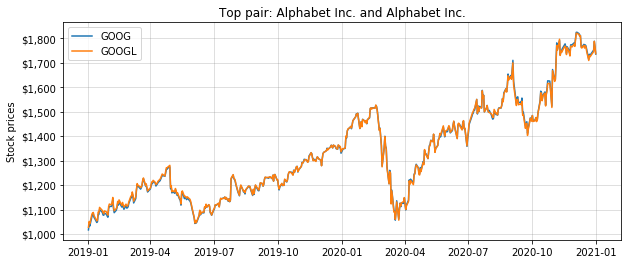

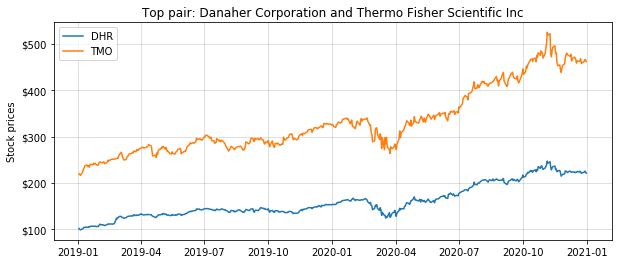

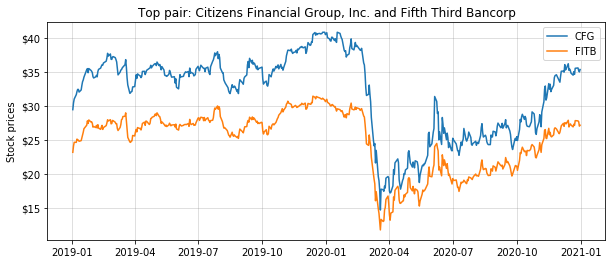

In [7]:
#show the top n pairs
n = 3
for i in range(0,n):
    plotting(i)

In [9]:
results.to_csv('Pairs.csv')

In [33]:
#Testing over last 60 days
from datetime import date, timedelta

start_date = date.today() - timedelta(days=60)
end_date = date.today() - timedelta(days=1)

symbols = results["Stock 1"].to_list() + results["Stock 2"].to_list()
symbols = list(set(symbols))

raw_data = yf.download(symbols, start=start_date, end=end_date)
pair_opening = raw_data["Open"]
pair_close = raw_data["Close"]

#def test():
    

[*********************100%***********************]  415 of 415 completed


In [34]:
pair_opening

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,WST,WU,WY,WYNN,XEL,XLNX,XOM,XRAY,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-25,126.690002,15.520000,163.679993,143.070007,109.730003,107.089996,113.059998,251.860001,474.510010,157.000000,...,302.440002,22.040001,33.220001,106.589996,64.599998,145.229996,46.900002,56.959999,47.470001,162.559998
2021-01-26,125.500000,15.520000,160.009995,143.600006,111.300003,107.669998,114.250000,253.190002,473.730011,153.929993,...,300.329987,22.830000,33.599998,109.250000,66.199997,146.389999,47.259998,57.320000,47.790001,161.350006
2021-01-27,122.080002,15.420000,152.649994,143.429993,106.279999,107.910004,115.199997,248.660004,470.989990,151.089996,...,294.940002,22.740000,32.759998,104.000000,65.370003,140.119995,45.000000,56.130001,44.669998,157.990005
2021-01-28,119.000000,20.330000,149.619995,139.520004,104.000000,107.379997,117.910004,249.240005,459.070007,150.369995,...,294.630005,23.430000,32.470001,102.099998,63.180000,137.050003,45.939999,55.799999,44.730000,154.300003
2021-01-29,121.209999,18.690001,153.000000,135.830002,104.000000,106.809998,120.250000,248.240005,462.170013,148.580002,...,297.690002,22.780001,32.599998,102.000000,63.180000,132.710007,45.549999,55.040001,45.290001,155.649994
2021-02-01,120.690002,17.250000,151.130005,133.750000,103.000000,104.860001,123.239998,246.100006,462.279999,148.339996,...,300.600006,22.420000,31.420000,100.919998,64.150002,132.440002,45.580002,53.910000,44.430000,156.199997
2021-02-02,122.500000,17.030001,151.869995,135.729996,102.879997,108.099998,123.400002,250.000000,473.649994,153.020004,...,300.000000,22.780001,32.250000,103.750000,63.880001,136.699997,45.810001,54.669998,45.279999,157.550003
2021-02-03,123.500000,16.610001,155.110001,135.759995,106.199997,105.180000,119.739998,248.190002,487.089996,152.000000,...,294.609985,22.799999,32.529999,106.699997,64.089996,137.479996,45.630001,54.830002,45.590000,157.320007
2021-02-04,122.510002,17.480000,156.529999,136.300003,106.870003,106.139999,119.830002,249.559998,484.220001,147.830002,...,292.890015,22.930000,33.910000,109.279999,63.080002,135.520004,47.880001,54.889999,46.400002,155.350006
